In [9]:
import argparse
import warnings
from datetime import datetime
from glob import glob
from shutil import copyfile
from collections import OrderedDict
from PIL import Image
from IPython.display import display

import torch
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

from models.generator import Generator as Generator
from models.blocks import LinearBlock, LinearBlockMultipleLayers
from tools.utils import *
from main import clip_load_model

from clipfont import clip

clip_model_name = 'ViT-B/32'
clip_model, clip_preprocess = clip.load(clip_model_name, device="cuda")

In [2]:
def get_transform(img_size=80, input_ch=1):
  if input_ch == 1:
      mean = [0.5]
      std = [0.5]
  else:
      mean = [0.5, 0.5, 0.5]
      std = [0.5, 0.5, 0.5]
  
  normalize = Normalize(mean=mean, std=std)
  transform = Compose([Resize((img_size, img_size)),
                        ToTensor(),
                        normalize])
  return transform

transform = get_transform()

In [10]:
def build_model(img_size=80, sty_dim=512, input_ch=1, device='cuda', use_linear_block=False):
    networks = {}
    networks['G'] = Generator(
        img_size,
        sty_dim,
        use_sn=False,
        device=device,
        input_ch=input_ch,
        output_ch=input_ch)
    networks['G_EMA'] = Generator(
        img_size,
        sty_dim,
        use_sn=False,
        device=device,
        input_ch=input_ch,
        output_ch=input_ch)
    if use_linear_block:
        networks['L'] = LinearBlockMultipleLayers(
            512,
            sty_dim,
            norm='none',
            act='relu',
            use_sn=False)

    if device is not None:
        # torch.cuda.set_device(args.device)
        for name, net in networks.items():
            # networks[name] = net.cuda(args.gpu)
            # networks[name] = net.cuda(args.device)
            networks[name] = net.to(device)
    return networks

In [11]:
def clip_load_model(
    model,
    checkpoint_path=None,
    requires_grad=False,
    device='cuda',
    model_name='ViT-B/32',
):
    if checkpoint_path is None:
        model, _ = clip.load(model_name, device=device, jit=False)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])

    if not requires_grad:
        for param in model.parameters():
            param.requires_grad = False
    return model

def load_model(networks, checkpoint_path=None, log_dir=None):
    if checkpoint_path is not None:
        load_file_path = checkpoint_path
    elif log_dir is not None:
        check_load = open(os.path.join(log_dir, "checkpoint.txt"), 'r')
        to_restore = check_load.readlines()[-1].strip()
        load_file_path = os.path.join(log_dir, to_restore)
    else:
        print("=> no checkpoint found at '{}'".format(log_dir))
        return

    if os.path.isfile(load_file_path):
        print("=> loading checkpoint '{}'".format(load_file_path))
        checkpoint = torch.load(load_file_path, map_location='cpu')
        for name, net in networks.items():
            tmp_keys = next(
                iter(checkpoint[name + '_state_dict'].keys()))
            if 'module' in tmp_keys:
                tmp_new_dict = OrderedDict()
                for key, val in checkpoint[name +
                                           '_state_dict'].items():
                    tmp_new_dict[key[7:]] = val
                net.load_state_dict(tmp_new_dict)
                networks[name] = net
            else:
                if checkpoint[name + '_state_dict'] is not None:
                    net.load_state_dict(checkpoint[name + '_state_dict'])
                    networks[name] = net

                print("=> loaded checkpoint '{}' (epoch {})"
                    .format(load_file_path, checkpoint['epoch']))

In [12]:
# clip_model_path = '/home/yuki/learn-computer-vision/CLIPFont/model_checkpoints/best_mixed_ViT-B_32_9101191011_batch32_single_character_use_negative_use_negative_loss1e-06_lr2e-05-0.1.pt'
clip_model_path = '/home/yuki/learn-computer-vision/CLIPFont/model_checkpoints/2_ViT-B_32_9101191011_batch64_aug250_use_negative_use_negative_loss1e-06_lr2e-05-0.1_image_file_dir.pt'
clip_model = clip_load_model(clip_model, checkpoint_path=clip_model_path, device='cuda')

In [13]:
sty_dim = 128
use_linear_block = True
networks = build_model(sty_dim=sty_dim, use_linear_block=use_linear_block)
model_name = 'GAN_20230904-215034'
log_dir = os.path.join('./logs', model_name)
checkpoint_path = os.path.join(log_dir, 'model_3.ckpt')
load_model(networks, checkpoint_path=checkpoint_path)
# load_model(networks, log_dir=log_dir)
G = networks['G']
L = None
if 'L' in networks:
    print('load L')
    L = networks['L']

Init Generator
GENERATOR NF :  64
Init ContentEncoder
Init Decoder
Init Generator
GENERATOR NF :  64
Init ContentEncoder
Init Decoder
=> loading checkpoint './logs/GAN_20230904-215034/model_3.ckpt'
=> loaded checkpoint './logs/GAN_20230904-215034/model_3.ckpt' (epoch 3)
=> loaded checkpoint './logs/GAN_20230904-215034/model_3.ckpt' (epoch 3)


RuntimeError: Error(s) in loading state_dict for LinearBlockMultipleLayers:
	Missing key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

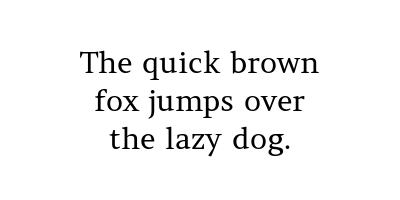

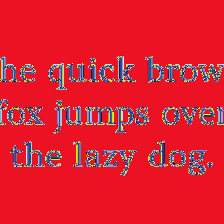

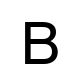

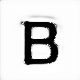

In [14]:
## Style Image
style_image_path = '../attributeData/grayscale_images/Roboto-MediumItalic.png'
style_image_path = '../grayscale_images_200/id_6.png'
# style_image_path = '../grayscale_images_200/id_3.png'
# style_image_path = '../attributeData/grayscale_images/Arimo-Bold.png'
style_image = Image.open(style_image_path)
display(style_image)
preprocessed_style_image = clip_preprocess(style_image).unsqueeze(0).to('cuda')
display(to_pil_image(preprocessed_style_image[0]))

## Content Image
content_image_path = '../gwfonts-images-DG-Font/id_6/0001.png'
content_image_path = '../gwfonts-images-DG-Font/id_0/0001.png'
content_image = Image.open(content_image_path).convert('L')
display(content_image)
transformed_content_image = transform(content_image).unsqueeze(0).to('cuda')

embedded_style_image = clip_model.encode_image(preprocessed_style_image).to(torch.float32)
if use_linear_block:
  embedded_style_image = L(embedded_style_image)
c_src, skip1, skip2 = G.cnt_encoder(transformed_content_image)
generated_image, _ = G.decode(c_src, embedded_style_image, skip1, skip2)
display(to_pil_image(generated_image[0].cpu()))

=> loading checkpoint './logs/GAN_20230905-003713/model_1.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_1.ckpt' (epoch 1)
=> loaded checkpoint './logs/GAN_20230905-003713/model_1.ckpt' (epoch 1)
=> loaded checkpoint './logs/GAN_20230905-003713/model_1.ckpt' (epoch 1)


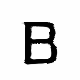

=> loading checkpoint './logs/GAN_20230905-003713/model_2.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_2.ckpt' (epoch 2)
=> loaded checkpoint './logs/GAN_20230905-003713/model_2.ckpt' (epoch 2)
=> loaded checkpoint './logs/GAN_20230905-003713/model_2.ckpt' (epoch 2)


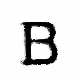

=> loading checkpoint './logs/GAN_20230905-003713/model_3.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_3.ckpt' (epoch 3)
=> loaded checkpoint './logs/GAN_20230905-003713/model_3.ckpt' (epoch 3)
=> loaded checkpoint './logs/GAN_20230905-003713/model_3.ckpt' (epoch 3)


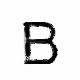

=> loading checkpoint './logs/GAN_20230905-003713/model_4.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_4.ckpt' (epoch 4)
=> loaded checkpoint './logs/GAN_20230905-003713/model_4.ckpt' (epoch 4)
=> loaded checkpoint './logs/GAN_20230905-003713/model_4.ckpt' (epoch 4)


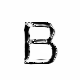

=> loading checkpoint './logs/GAN_20230905-003713/model_5.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_5.ckpt' (epoch 5)
=> loaded checkpoint './logs/GAN_20230905-003713/model_5.ckpt' (epoch 5)
=> loaded checkpoint './logs/GAN_20230905-003713/model_5.ckpt' (epoch 5)


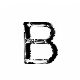

=> loading checkpoint './logs/GAN_20230905-003713/model_6.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_6.ckpt' (epoch 6)
=> loaded checkpoint './logs/GAN_20230905-003713/model_6.ckpt' (epoch 6)
=> loaded checkpoint './logs/GAN_20230905-003713/model_6.ckpt' (epoch 6)


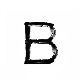

=> loading checkpoint './logs/GAN_20230905-003713/model_7.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_7.ckpt' (epoch 7)
=> loaded checkpoint './logs/GAN_20230905-003713/model_7.ckpt' (epoch 7)
=> loaded checkpoint './logs/GAN_20230905-003713/model_7.ckpt' (epoch 7)


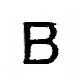

=> loading checkpoint './logs/GAN_20230905-003713/model_8.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_8.ckpt' (epoch 8)
=> loaded checkpoint './logs/GAN_20230905-003713/model_8.ckpt' (epoch 8)
=> loaded checkpoint './logs/GAN_20230905-003713/model_8.ckpt' (epoch 8)


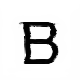

=> loading checkpoint './logs/GAN_20230905-003713/model_9.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_9.ckpt' (epoch 9)
=> loaded checkpoint './logs/GAN_20230905-003713/model_9.ckpt' (epoch 9)
=> loaded checkpoint './logs/GAN_20230905-003713/model_9.ckpt' (epoch 9)


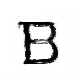

=> loading checkpoint './logs/GAN_20230905-003713/model_10.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_10.ckpt' (epoch 10)
=> loaded checkpoint './logs/GAN_20230905-003713/model_10.ckpt' (epoch 10)
=> loaded checkpoint './logs/GAN_20230905-003713/model_10.ckpt' (epoch 10)


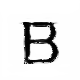

=> loading checkpoint './logs/GAN_20230905-003713/model_11.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_11.ckpt' (epoch 11)
=> loaded checkpoint './logs/GAN_20230905-003713/model_11.ckpt' (epoch 11)
=> loaded checkpoint './logs/GAN_20230905-003713/model_11.ckpt' (epoch 11)


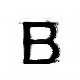

=> loading checkpoint './logs/GAN_20230905-003713/model_12.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_12.ckpt' (epoch 12)
=> loaded checkpoint './logs/GAN_20230905-003713/model_12.ckpt' (epoch 12)
=> loaded checkpoint './logs/GAN_20230905-003713/model_12.ckpt' (epoch 12)


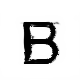

=> loading checkpoint './logs/GAN_20230905-003713/model_13.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_13.ckpt' (epoch 13)
=> loaded checkpoint './logs/GAN_20230905-003713/model_13.ckpt' (epoch 13)
=> loaded checkpoint './logs/GAN_20230905-003713/model_13.ckpt' (epoch 13)


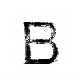

=> loading checkpoint './logs/GAN_20230905-003713/model_14.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_14.ckpt' (epoch 14)
=> loaded checkpoint './logs/GAN_20230905-003713/model_14.ckpt' (epoch 14)
=> loaded checkpoint './logs/GAN_20230905-003713/model_14.ckpt' (epoch 14)


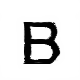

=> loading checkpoint './logs/GAN_20230905-003713/model_15.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_15.ckpt' (epoch 15)
=> loaded checkpoint './logs/GAN_20230905-003713/model_15.ckpt' (epoch 15)
=> loaded checkpoint './logs/GAN_20230905-003713/model_15.ckpt' (epoch 15)


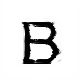

=> loading checkpoint './logs/GAN_20230905-003713/model_16.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_16.ckpt' (epoch 16)
=> loaded checkpoint './logs/GAN_20230905-003713/model_16.ckpt' (epoch 16)
=> loaded checkpoint './logs/GAN_20230905-003713/model_16.ckpt' (epoch 16)


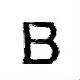

=> loading checkpoint './logs/GAN_20230905-003713/model_17.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_17.ckpt' (epoch 17)
=> loaded checkpoint './logs/GAN_20230905-003713/model_17.ckpt' (epoch 17)
=> loaded checkpoint './logs/GAN_20230905-003713/model_17.ckpt' (epoch 17)


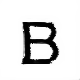

=> loading checkpoint './logs/GAN_20230905-003713/model_18.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_18.ckpt' (epoch 18)
=> loaded checkpoint './logs/GAN_20230905-003713/model_18.ckpt' (epoch 18)
=> loaded checkpoint './logs/GAN_20230905-003713/model_18.ckpt' (epoch 18)


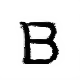

=> loading checkpoint './logs/GAN_20230905-003713/model_19.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_19.ckpt' (epoch 19)
=> loaded checkpoint './logs/GAN_20230905-003713/model_19.ckpt' (epoch 19)
=> loaded checkpoint './logs/GAN_20230905-003713/model_19.ckpt' (epoch 19)


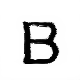

=> loading checkpoint './logs/GAN_20230905-003713/model_20.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_20.ckpt' (epoch 20)
=> loaded checkpoint './logs/GAN_20230905-003713/model_20.ckpt' (epoch 20)
=> loaded checkpoint './logs/GAN_20230905-003713/model_20.ckpt' (epoch 20)


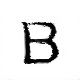

=> loading checkpoint './logs/GAN_20230905-003713/model_21.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_21.ckpt' (epoch 21)
=> loaded checkpoint './logs/GAN_20230905-003713/model_21.ckpt' (epoch 21)
=> loaded checkpoint './logs/GAN_20230905-003713/model_21.ckpt' (epoch 21)


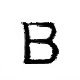

=> loading checkpoint './logs/GAN_20230905-003713/model_22.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_22.ckpt' (epoch 22)
=> loaded checkpoint './logs/GAN_20230905-003713/model_22.ckpt' (epoch 22)
=> loaded checkpoint './logs/GAN_20230905-003713/model_22.ckpt' (epoch 22)


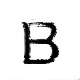

=> loading checkpoint './logs/GAN_20230905-003713/model_23.ckpt'
=> loaded checkpoint './logs/GAN_20230905-003713/model_23.ckpt' (epoch 23)
=> loaded checkpoint './logs/GAN_20230905-003713/model_23.ckpt' (epoch 23)
=> loaded checkpoint './logs/GAN_20230905-003713/model_23.ckpt' (epoch 23)


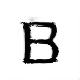

In [15]:
model_name = 'GAN_20230904-154414'
model_name = 'GAN_20230904-182524'
model_name = 'GAN_20230904-215034'
model_name = 'GAN_20230905-003713'
log_dir = os.path.join('./logs', model_name)
for i in range(1, 24):
  checkpoint_path = os.path.join(log_dir, f'model_{i}.ckpt')
  load_model(networks, checkpoint_path=checkpoint_path)
  # load_model(networks, log_dir=log_dir)
  G = networks['G']
  embedded_style_image = clip_model.encode_image(preprocessed_style_image).to(torch.float32)
  if use_linear_block:
    L = networks['L']
    embedded_style_image = L(embedded_style_image)
  c_src, skip1, skip2 = G.cnt_encoder(transformed_content_image)
  generated_image, _ = G.decode(c_src, embedded_style_image, skip1, skip2)
  display(to_pil_image(generated_image[0].cpu()))